# Analyzing Trucking Data Using SQL and Python
**Bosun Anifowoshe**

bosunani@gmail.com

### Import useful libraries

Note: I will be using the sqlalchemy library for the SQL portion of this assessment. It stores the database in a simple file and can be run in a "standalone" mode from the command-line. However, I will, naturally, [invoke it from Python]. But all of the basic techniques apply to any commercial SQL backend.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
from scipy.stats import pearsonr
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

### Data Load and Preprocessing

First I load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [2]:
#load data
df = pd.read_csv('nbl_eval.csv')
#change relevant variables to category type
df['truckingcompanyid'] = df['truckingcompanyid'].astype('category')
df['productid'] = df['productid'].astype('category')
df['source'] = df['source'].astype('category')
df['destination'] = df['destination'].astype('category')
#store data as sql database
df.to_sql('nbl_eval', con=engine, if_exists='replace', index=True)

In [3]:
#load first 10 rows of data
query = '''
  SELECT * 
  FROM nbl_eval
  limit 10
'''
pd.read_sql_query(query, engine)

,index,truckingcompanyid,productid,distanceinmiles,fuelcost,linehaulcost,source,destination
0,0,7739,13,291.96,5.67,2821.21,San Antonio,Houston
1,1,1877,23,778.56,6.19,290.03,Detroit,San Francisco
2,2,3019,9,2433.00,4.55,682.18,San Diego,Tucson
3,3,6995,18,389.28,6.54,183.41,Minneapolis,New Orleans
4,4,7583,21,1946.40,6.58,238.36,New Orleans,Baltimore
5,5,6203,6,3114.24,5.32,315.81,Omaha,San Diego
6,6,9390,3,778.56,4.34,354.62,Sacramento,Memphis
7,7,6576,14,389.28,5.05,637.52,Boston,Oklahoma City
8,8,2382,7,681.24,5.81,76.64,Virginia Beach,Atlanta
9,9,5102,6,291.96,6.88,755.22,Sacramento,Tucson


- Quick observation of the data indicates we have 4 categorical variables (truckingcompanyid, productid, source, destination) and 3 continous variables (distanceinmiles, fuelcost, linehaulcost)

# SQL, data wrangling

### 1a. Descriptive Statistics

To begin the analysis, I will like to do a quick exploratory data analysis and investigate descriptive stats like avg, min, max, stdev for each continous variable. I will also like to see the number of unique items for the categorical variables

In [4]:
#extract avg, min, max for continous variables
query = '''
select *
from
    ( select 5,
            productid,
            distanceinmiles,
            fuelcost,
            linehaulcost
    from nbl_eval
    union select 1,
                'count',
                count(distanceinmiles),
                count(fuelcost),
                count(linehaulcost)
    from nbl_eval
    union select 2,
                'avg',
                avg(distanceinmiles),
                avg(fuelcost),
                avg(linehaulcost)
    from nbl_eval
    union select 3,
                'min',
                min(distanceinmiles),
                min(fuelcost),
                min(linehaulcost)
    from nbl_eval
    union select 4,
                'max',
                max(distanceinmiles),
                max(fuelcost),
                max(linehaulcost)
    from nbl_eval) stats
order by 1
'''
pd.read_sql_query(query, engine).head()

,5,productid,distanceinmiles,fuelcost,linehaulcost
0,1,count,10286.000000,10286.000000,10286.000000
1,2,avg,1616.187544,5.499473,830.179412
2,3,min,97.320000,2.150000,7.490000
3,4,max,4671.360000,9.550000,34845.530000
4,5,1,97.320000,4.420000,14267.280000


In [5]:
#extract count of unique categorical variables
query = '''
select count (distinct truckingcompanyid), 
        count (distinct productid), 
        count (distinct source), 
        count (distinct destination)
from nbl_eval
'''
pd.read_sql_query(query, engine).head()

,count (distinct truckingcompanyid),count (distinct productid),count (distinct source),count (distinct destination)
0,6153,24,49,49


Additional stats like the percentiles for the continous variables and the other stats computed ablve can be obtained by just onle line of code below

In [6]:
#descriptive stats pandas
round(df.describe(include='all'),0)

,truckingcompanyid,productid,distanceinmiles,fuelcost,linehaulcost,source,destination
count,10286.0,10286.0,10286.0,10286.0,10286.0,10286,10286
unique,6153.0,24.0,NaN,NaN,NaN,49,49
top,5367.0,4.0,NaN,NaN,NaN,Phoenix,New Orleans
freq,8.0,464.0,NaN,NaN,NaN,242,262
mean,NaN,NaN,1616.0,5.0,830.0,NaN,NaN
std,NaN,NaN,1109.0,1.0,1697.0,NaN,NaN
min,NaN,NaN,97.0,2.0,7.0,NaN,NaN
25%,NaN,NaN,681.0,5.0,150.0,NaN,NaN
50%,NaN,NaN,1460.0,6.0,326.0,NaN,NaN
75%,NaN,NaN,2433.0,6.0,772.0,NaN,NaN


- A potential outlier is observed for the linehaulcost variable since the maximum value (34,846) is way bigger compared to the avarage value (830).

###  1b. Data Consistency

To check for data consistency, I will check for:
- verify that all rows of data are unique
- verify that all unique source-destination route has the same distance in miles

In [7]:
#check for all unique rows
query = '''
Select truckingcompanyid, productid, distanceinmiles, fuelcost, linehaulcost, source, destination, 
    count(*)
    From nbl_eval 
    group by truckingcompanyid, productid, distanceinmiles, fuelcost, linehaulcost, source, destination
    having count(*) > 1
   '''
pd.read_sql_query(query, engine)

,truckingcompanyid,productid,distanceinmiles,fuelcost,linehaulcost,source,destination,count(*)


In [8]:
#check for equal distance for all unique source-destination route
query = '''
Select source || '-' || destination as 'Source-Destination', count(distinct distanceinmiles)
    From nbl_eval 
    group by source || '-' || destination
    having count(distinct distanceinmiles) > 1
   '''
pd.read_sql_query(query, engine)

,Source-Destination,count(distinct distanceinmiles)


- As shown by the above results, the query returned nothing for both checks. this indicates that the data seems consistent and no anomalies observed. However, as observed in the descriptive stats there is potentially an outlier in the linehaul cost variable. To investigate this further, I will generate so boxplot and histogram for each continous variable.

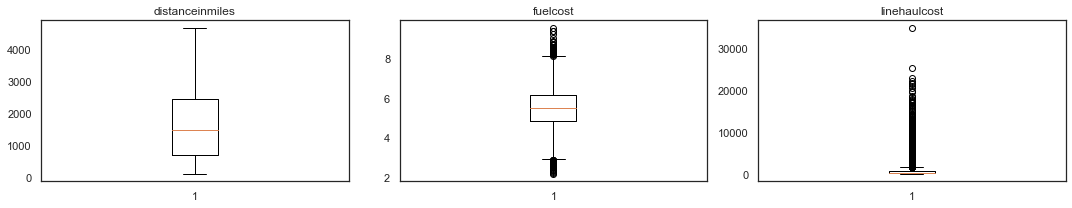

In [9]:
#create boxplots for continous variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].boxplot(df['distanceinmiles'])
axes[0].set_title('distanceinmiles')
axes[1].boxplot(df['fuelcost'])
axes[1].set_title('fuelcost')
axes[2].boxplot(df['linehaulcost'])
axes[2].set_title('linehaulcost')
fig.tight_layout()

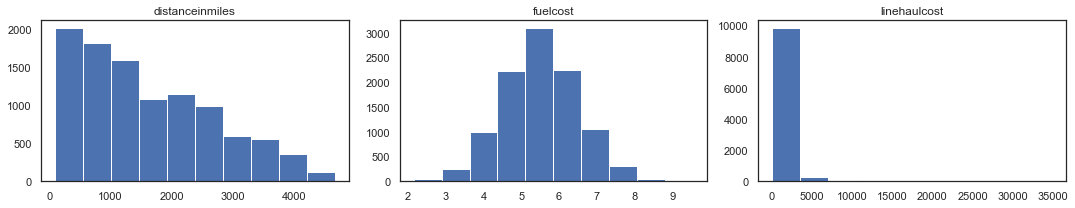

In [10]:
#create histograms for continous variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].hist(df['distanceinmiles'])
axes[0].set_title('distanceinmiles')
axes[1].hist(df['fuelcost'])
axes[1].set_title('fuelcost')
axes[2].hist(df['linehaulcost'])
axes[2].set_title('linehaulcost')
fig.tight_layout()

- As observed, the boxplot confirms the presence of an outlier in the dataset. The histogram shows the distribution of the dataset, and the linehaulcost variable showa a long tail to the right of the distribution which also confirms the outlier. Further investigation need done to ensure this data point is anomalous before ommiting it from the analysis. 

### 2. Data Sampling

I will sample the data via a randomized approach as shown by the query below.

In [11]:
#select 8000 random observations and display the descriptive stats
query = '''
SELECT * FROM nbl_eval
ORDER BY RANDOM()
LIMIT 8000
   '''
sample = pd.read_sql_query(query, engine)
round(sample.describe(include='all'),0)


,index,truckingcompanyid,productid,distanceinmiles,fuelcost,linehaulcost,source,destination
count,8000.0,8000,8000,8000.0,8000.0,8000.0,8000,8000
unique,NaN,5293,24,NaN,NaN,NaN,49,49
top,NaN,5367,4,NaN,NaN,NaN,Phoenix,New Orleans
freq,NaN,7,367,NaN,NaN,NaN,197,211
mean,5148.0,NaN,NaN,1624.0,5.0,838.0,NaN,NaN
std,2978.0,NaN,NaN,1112.0,1.0,1736.0,NaN,NaN
min,0.0,NaN,NaN,97.0,2.0,7.0,NaN,NaN
25%,2561.0,NaN,NaN,681.0,5.0,151.0,NaN,NaN
50%,5131.0,NaN,NaN,1460.0,5.0,325.0,NaN,NaN
75%,7742.0,NaN,NaN,2433.0,6.0,773.0,NaN,NaN


- As shown by the table above, the descriptive stats is similar to the one for the entire dataset. This is because of the amount of observations sampled (80%) from the dataset. 

### 3. Top 10 most expensive trucking companies

To determine the most expensive trucking companies, I will normalize the total linehaulcost by the total distanceinmiles for each company and sort descending.

Note that I did not remove the outlier from the dataset.

In [12]:
query = '''
SELECT *
FROM (
SELECT truckingcompanyid, sum(linehaulcost)/sum(distanceinmiles) as costpermile,
RANK() OVER(ORDER BY sum(linehaulcost)/sum(distanceinmiles) DESC) AS rowrank
FROM nbl_eval
GROUP BY  truckingcompanyid)
WHERE rowrank <=10
   '''
pd.read_sql_query(query, engine)

,truckingcompanyid,costpermile,rowrank
0,1699,358.051069,1
1,6665,228.812577,2
2,5287,211.680436,3
3,8645,199.953144,4
4,9108,191.236642,5
5,6832,180.003288,6
6,6857,178.353062,7
7,2205,168.523222,8
8,3849,161.163379,9
9,1598,146.787711,10


### 4. Top 10 most source-destination routes companies

To determine the most source-destination routes trucking companies, I will concatenate the source-destination attributes, count unique occurence and sort descending.

In [13]:
query = '''
SELECT *
FROM (SELECT truckingcompanyid, COUNT(distinct source || '-' || destination) as sourcedestinationcount,
RANK() OVER(ORDER BY COUNT(distinct source || '-' || destination) DESC) AS rowrank
FROM nbl_eval
GROUP BY  truckingcompanyid)
WHERE rowrank <= 10

   '''
pd.read_sql_query(query, engine)

,truckingcompanyid,sourcedestinationcount,rowrank
0,5367,8,1
1,4835,7,2
2,1414,6,3
3,1601,6,3
4,1953,6,3
5,2213,6,3
6,2281,6,3
7,3442,6,3
8,3925,6,3
9,6456,6,3


- Note that I returned 13 companies because 11 companies had the same count of 6 routes

### 5. Check for Collinearity

To check for colinearity, I will crossplot the variables and determine the r2.

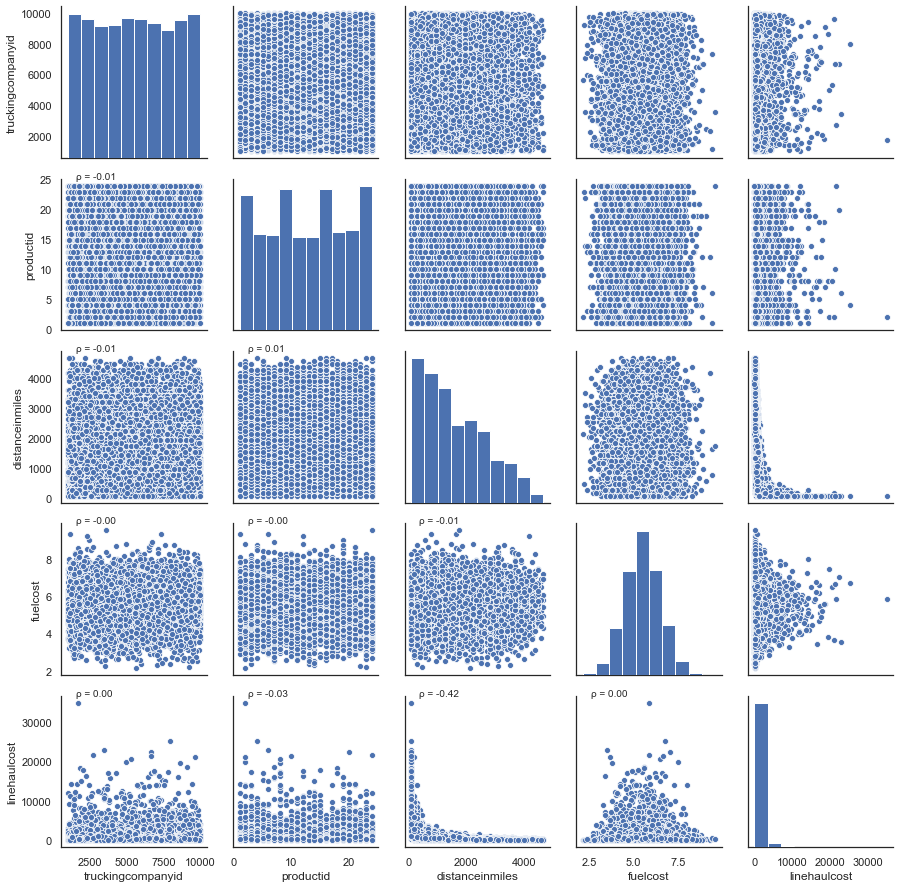

In [14]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, 1), xycoords=ax.transAxes)

g = sns.pairplot(df)
g.map_lower(corrfunc)
plt.show()

- As observed from the plots above, very little to no correlation exists between variables wich indicates no collinearity between them. The sightly negative correlation occurs between linehaulcost and distanceinmiles which is conterintuitive to what you would expect. Other methods such as the variable inflation factor can be used to test for multicolinearity but isn't shown here.
- In addition, although not shown on the above plots, distanceinmiles correlates to a source-destination route. That is, the same source-destination observation in the dataset will have the same distanceinmiles.

# Science / Machine learning

This section will provide analysis for 4 different regression algorithms
- Decision Tree, Neural Network, Boosting, KNN.

There will be two outputs for each model: a plot of learning curve and a plot of model complexity. Both plots will be generated after hyperparameter tuning is performed.

### Data Preprocessing

In [15]:
#make a copy of data for ML
df_ML = df.copy()
df_ML.head()

,truckingcompanyid,productid,distanceinmiles,fuelcost,linehaulcost,source,destination
0,7739,13,291.96,5.67,2821.21,San Antonio,Houston
1,1877,23,778.56,6.19,290.03,Detroit,San Francisco
2,3019,9,2433.00,4.55,682.18,San Diego,Tucson
3,6995,18,389.28,6.54,183.41,Minneapolis,New Orleans
4,7583,21,1946.40,6.58,238.36,New Orleans,Baltimore


- This data need some preprocessing. Several of the columns are categorical. For the categorical variables, I will use one-hot encoding to create additional features with level {0,1}. This is necessary to improve the accuracy of the models.

In [16]:
import category_encoders as ce
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['truckingcompanyid','productid', 'source', 'destination'],use_cat_names=True)
# encode the categorical variables
df_OHE = OHE.fit_transform(df_ML)
df_OHE.head()

,truckingcompanyid_7739.0,truckingcompanyid_1877.0,truckingcompanyid_3019.0,truckingcompanyid_6995.0,truckingcompanyid_7583.0,truckingcompanyid_6203.0,truckingcompanyid_9390.0,truckingcompanyid_6576.0,truckingcompanyid_2382.0,truckingcompanyid_5102.0,...,destination_Boston,destination_Fort Worth,destination_El Paso,destination_Detroit,destination_Washington,destination_Seattle,destination_Jacksonville,destination_Oakland,destination_Phoenix,destination_Indianapolis
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print("Data has",len(df_OHE),"rows and", len(df_OHE.columns),"columns.")

Data has 10286 rows and 6278 columns.


- As observed, the processed data has 10286 rows and 6278 columns. It is not practical to analyze this data with so many columns and definitely, any model built with this data will suffer from the curse of dimensionality. For all practical purpose for this assessment, I will not be transforming the categorical variables and will be using it as is. 
- In addition, I will be removing the source and destination data from the analysis because each unique source-destination has the same distanceinmiles

In [18]:
#additional data processing
df_ML2 = df.drop(columns=['source', 'destination'])
column_order = list(df_ML2)
column_order.insert(0, column_order.pop(column_order.index('linehaulcost')))
df_ML2 = df_ML2.loc[:, column_order]  #move the target variable 'Result' to the front
df_ML2.head()

,linehaulcost,truckingcompanyid,productid,distanceinmiles,fuelcost
0,2821.21,7739,13,291.96,5.67
1,290.03,1877,23,778.56,6.19
2,682.18,3019,9,2433.00,4.55
3,183.41,6995,18,389.28,6.54
4,238.36,7583,21,1946.40,6.58


### Helper Functions

Before I get into the algorithms, I'll define some helper functions that will be used across all of the models. I will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). I will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (regression model). Finally, I define functions to output final model scores using an untouched test dataset.

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler, normalize
import itertools
import timeit

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_ML2.values[:,1:],dtype='int64')
    Y1 = np.array(df_ML2.values[:,0],dtype='int64')
    return X1, Y1


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        kfold = KFold(10, False, 2)
        scores = cross_validate(clf, X_subset, y_subset, cv=kfold, scoring='r2', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean, cv_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model r2 Score")
    plt.plot(train_sizes, train_mean, 'o-', color="black", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="grey", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.plot(train_sizes, fit_mean, 'o-', color="black", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="grey", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
   
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    r2 = r2_score(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("r2:  "+"{:.2f}".format(r2))


### Decision Tree

This section will build a Decision Tree using information gain (based on entropy) to determine the best feature split per the ID3 algorithm. The model will be pre-pruned by limiting tree depth using the hyperparameter 'max_depth' and by ensuring that each leaf (a terminal node on the tree) has at least 'min_samples_leaf'.

In [20]:
from sklearn.tree import DecisionTreeRegressor

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    r2_test = []
    r2_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeRegressor(max_depth=i, random_state=100, min_samples_leaf=1)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            r2_test.append(r2_score(y_test, y_pred_test))
            r2_train.append(r2_score(y_train, y_pred_train))
      
    plt.plot(max_depth, r2_train, 'o-', color = 'black', label='Train r2 Score')
    plt.plot(max_depth, r2_test, 'o-', color='grey', label='Test r2 Score')
    plt.ylabel('Model r2 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'max_depth':np.arange(1,30)}
    kfold = KFold(10, False, 2)
    tree = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid=param_grid, cv=kfold)
    tree.fit(X_train, y_train)
    print("Best Prunning Parameters Based on Hyperparameter Tuning")
    print("*******************************************************")
    print(tree.best_params_)
    print("*******************************************************")
    return tree.best_params_['max_depth']

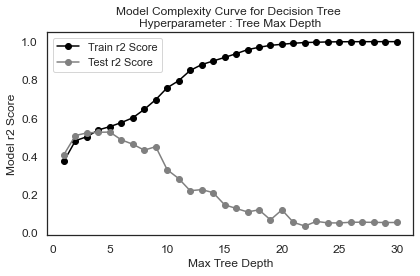

Best Prunning Parameters Based on Hyperparameter Tuning
*******************************************************
{'max_depth': 2}
*******************************************************


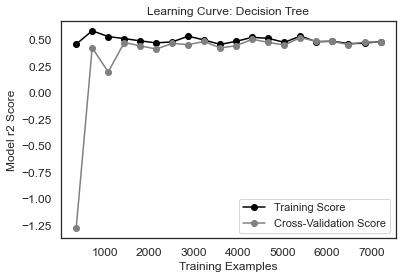

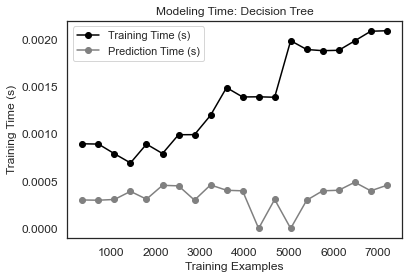

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00247
Model Prediction Time (s): 0.00010

r2:  0.51


In [21]:
X,Y = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(Y), test_size=0.30,  random_state=0)
hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree \nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_MT = DecisionTreeRegressor(max_depth=max_depth, random_state=100)
train_samp_MT, DT_train_score_MT, DT_fit_time_MT, DT_pred_time_MT, DT_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Decision Tree")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

- The top plot illustrates the impact of overfitting on the data set. The black curve shows the r2 score of the decision tree over the training set, whereas the grey curve shows r2 score measured over an independent set of test set. As observed, the r2 score of the tree over the training set increases monotonically and then flattens out as the tree is grown. However, the r2 score measured over the independent test set first increases, then decreases before flattening out. Once the tree size exceeds approximately max tree depth of 8, further elaboration of the tree decreases the r2 score over the test set despite increasing its r2 score on the training set. This phenomenon occurs due to the fact that the training data contain random errors or noise that the decision tree is trying to fit thereby causing overfitting. In addition, the r2 is low for the test data and can possibly be improved by transforming the categorical variables.
- Next, using the max tree depth 2 (from hyperparameter tuning), learning curve were generated by training and cross validating on portions of the training set as shown in second plot. The black curve shows the r2 score of the decision tree over the training set, whereas the grey curve shows r2 score measured by performing cross validation on the training set. The learning curve tells us how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. Ideally, with smaller training sets, we expect the training error will be low because it will be easier to fit to less data. So as training set size grows, the average training set error is expected to grow. Conversely, we expect the average validation error to decrease as the training set size increases. For this analysis we do not see any benefit in the accuracy of the test set beyond training sample of about 1000.
- This model yields an r2 of 0.51 on the test set which means that about 51% of the variiability in linehaulcost is explained by this model.
- Finally, the training and prediction times are reported. The training time is much higher than the time it takes for testing which makes sense because the ID3 algorithm used is an eager learner.

### Feature Importance

I will utilize the Decision Tree model to determine the relative importance of each variable.

In [22]:
# decision tree for feature importance on a regression problem
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.31730
Feature: 1, Score: 0.10797
Feature: 2, Score: 0.49952
Feature: 3, Score: 0.07521


- As observed above, distanceinmiles is the most importance variable (variable that reduces the overall error of the model) which makes sense because the distanceinmiles of the shipped products has the highest correlation to linehaulcost
- The variables can be ranked in order of priority as linehaulcost > truckingcompanyid > productid > fuelcost

### Boosted Decision Tree

This section will implement a boosted version of the earlier decision tree. I will still keep the pruning based on max_depth and min_samples_leaf, but the cutoff thresholds will be more aggressive (lower) since the power of boosting is to combine multiple weak learners. I also introduce the hyperparameter of n_estimators which will determine the contribution of each tree classifier.

In [23]:
from sklearn.ensemble import AdaBoostRegressor

def hyperBoost1(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    r2_test = []
    r2_train = []
    n_estimators = np.linspace(1,500,40).astype('int')
    tree = DecisionTreeRegressor(random_state=100, max_depth=1)
    for i in n_estimators:         
            clf = AdaBoostRegressor(base_estimator=tree, n_estimators=i, random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            r2_test.append(r2_score(y_test, y_pred_test))
            r2_train.append(r2_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, r2_train, 'o-', color = 'black', label='Train r2 Score')
    plt.plot(n_estimators, r2_test, 'o-', color='grey', label='Test r2 Score')
    plt.ylabel('Model r2 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'n_estimators': np.linspace(10,500,10).round().astype('int')}
    kfold = KFold(10, False, 2)
    boost = GridSearchCV(estimator = AdaBoostRegressor(), param_grid=param_grid, cv=kfold)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['n_estimators']

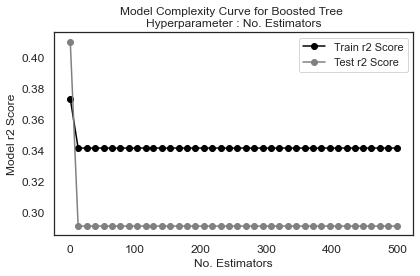

Per Hyperparameter tuning, best parameters are:
{'n_estimators': 500}


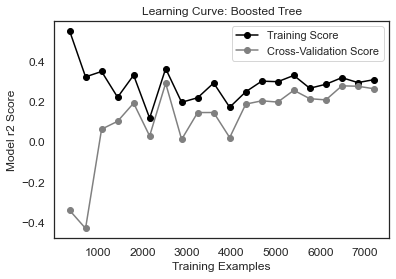

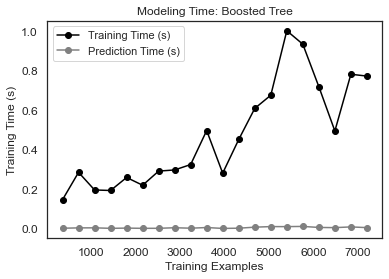

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.68103
Model Prediction Time (s): 0.04207

r2:  0.26


In [24]:
hyperBoost1(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree \nHyperparameter : No. Estimators")

start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
n_est = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
tree = DecisionTreeRegressor(random_state=100, max_depth=1)
estimator_MT = AdaBoostRegressor(base_estimator=tree, n_estimators=n_est, learning_rate=0.05, random_state=100)
train_samp_MT, BT_train_score_MT, BT_fit_time_MT, BT_pred_time_MT, BT_cv_mean_MT = plot_learning_curve(estimator_MT, X_train, y_train,title="Boosted Tree")
final_classifier_evaluation(estimator_MT, X_train, X_test, y_train, y_test)

- The AdaBoost algorithm with decision tree stumps as weak learners to improve the performance for the classification problem. Generally speaking, boosting can lead to a decrease in bias as well as variance however, some boosting algorithms such as AdaBoost are also known for their high variance, that is, the tendency to overfit the training data, hence some form of pre-pruning was performed by limiting the number of sequential trees to be modeled and the learning rate which determines the impact of each tree on the final outcome. If the learning rate is too large, the algorithm will overshoot the global cost minimum. If the learning rate is too small, the algorithm requires more epochs until convergence, which can make the learning slow—especially for large datasets.
- The top plots show the hyperparameter tuning for the number of estimators. As observed, the r2 score of the tree over both the training and test set remains relatively flat as the number of estimators increases. This model yields an r2 of 0.38 on the test set which means that about 38% of the variiability in linehaulcost is explained by this model.
- Next I performed hyperparameter tuning to select the best number of estimators resulted in 10 estimators. These parameters were used in generating learning curve by training and cross validating on portions of the training set as shown above.
- Finally, the training time is much higher than the time it takes for testing which comes from the fact that the algorithm is building multiple trees during training and then combining them into a single classifier for testing.


### Neural Network

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate.

In [25]:
from sklearn.neural_network import MLPRegressor

def hyperNN(X_train, y_train, X_test, y_test, title):

    r2_test = []
    r2_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPRegressor(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            r2_test.append(r2_score(y_test, y_pred_test))
            r2_train.append(r2_score(y_train, y_pred_train))
      
    plt.plot(hlist, r2_train, 'o-', color = 'black', label='Train r2 Score')
    plt.plot(hlist, r2_test, 'o-', color='grey', label='Test r2 Score')
    plt.ylabel('Model r2 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()  
    
def NNGridSearchCV(X_train, y_train):
    h_units = [5, 20, 40, 75, 100]
    #learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units}
    kfold = KFold(10, False, 2)
    net = GridSearchCV(estimator = MLPRegressor(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=kfold)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes']

In [26]:
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

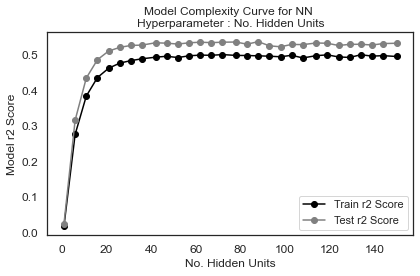

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 100}


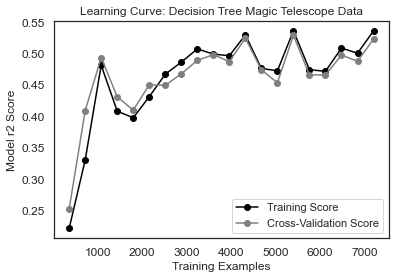

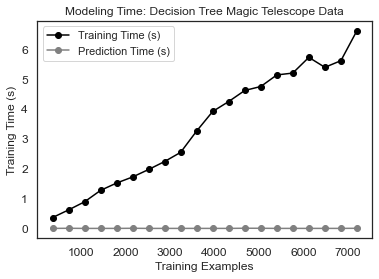

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   2.83311
Model Prediction Time (s): 0.00379

r2:  0.53


In [27]:
import warnings
warnings.filterwarnings('ignore')
hyperNN(X_train_scaled, y_train, X_test_scaled, y_test,title="Model Complexity Curve for NN \nHyperparameter : No. Hidden Units")
h_units = NNGridSearchCV(X_train_scaled, y_train)
estimator_MT = MLPRegressor(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=0.05, random_state=100)
train_samp_MT, NN_train_score_MT, NN_fit_time_MT, NN_pred_time_MT, NN_cv_mean_MT = plot_learning_curve(estimator_MT, X_train_scaled, y_train,title="Decision Tree Magic Telescope Data")
final_classifier_evaluation(estimator_MT, X_train_scaled, X_test_scaled, y_train, y_test)

- For this analysis, a network structure with one hidden layer was used while the number of hidden units was the main hyperparameter tuned to optimize the model. As observed, the r2 score of the tree for both the training and test set increases monotonically and then flattens out as the number of hidden unit increases. The hyperparameter tuning shows that hidden layers = 100 is optimal for this analysis. This model yields an r2 of 0.53 on the test set which means that about 53% of the variiability in linehaulcost is explained by this model.
- In addition, the training time is much higher than the time it takes for testing which comes from the fact that the back-propagation algorithm is an eager learner. 

No handles with labels found to put in legend.


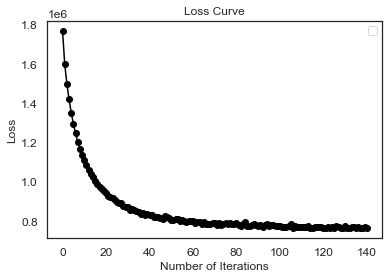

In [28]:
import warnings
warnings.filterwarnings('ignore')

estimator_MT = MLPRegressor(hidden_layer_sizes=(75,), solver='adam', activation='logistic', 
                               learning_rate_init=0.1, random_state=100)
estimator_MT.fit(X_train_scaled, y_train)
a = estimator_MT.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(a, 'o-', color="black")
plt.legend(loc="best")
plt.show()

- Finally, the figure above shows the loss curve for using the full training set and a learning rate of 0.1. As observed, we see aconvergence after about 40 iterations.

### KNN Classifier

This section will build a classifier using K-nearest neighbors. The hyperparameter will be n_neighbors. One could easily add another hyperparameter is the distance metric, but for simplicity, and for the sake of running the code faster, I won't explore this. I will use the standard euclidean distance for all models. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [29]:
from sklearn.neighbors import KNeighborsRegressor as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    r2_test = []
    r2_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1, weights = "distance")
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        r2_test.append(r2_score(y_test, y_pred_test))
        r2_train.append(r2_score(y_train, y_pred_train))
        
    plt.plot(klist, r2_train, 'o-', color = 'black', label='Train r2 Score')
    plt.plot(klist, r2_test, 'o-', color='grey', label='Test r2 Score')
    plt.ylabel('Model r2 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

def kNNGridSearchCV(X_train, y_train):
    neighbors = np.linspace(1,250,25).astype('int')
    distance = [1, 2]
    param_grid = {'n_neighbors': neighbors, 'p': distance}
    kfold = KFold(10, False, 2)
    knn = GridSearchCV(estimator = kNN(n_jobs=-1, weights = "distance"),
                       param_grid=param_grid, cv=kfold)
    knn.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(knn.best_params_)
    return knn.best_params_['n_neighbors'], knn.best_params_['p']

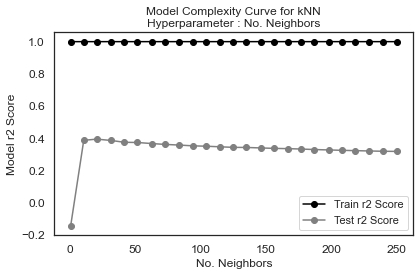

Per Hyperparameter tuning, best parameters are:
{'n_neighbors': 21, 'p': 1}


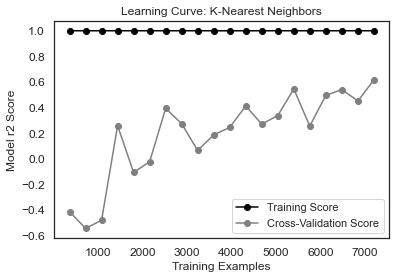

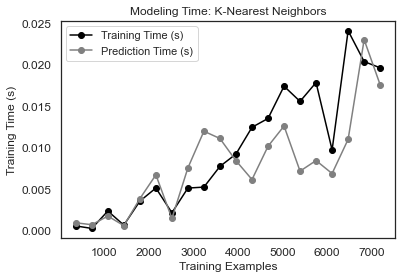

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00505
Model Prediction Time (s): 0.10473

r2:  -0.02


In [30]:
hyperKNN(X_train_scaled, y_train, X_test_scaled, y_test,title="Model Complexity Curve for kNN\nHyperparameter : No. Neighbors")
neighbors, distance= kNNGridSearchCV(X_train_scaled, y_train)
estimator_MT = kNN(n_neighbors=distance, p = distance, n_jobs=-1, weights = "distance")
train_samp_MT, kNN_train_score_MT, kNN_fit_time_MT, kNN_pred_time_MT, kNN_cv_mean_MT = plot_learning_curve(estimator_MT, X_train_scaled, y_train,title="K-Nearest Neighbors")
final_classifier_evaluation(estimator_MT, X_train_scaled, X_test_scaled, y_train, y_test)

- We observe r2 score to be relatively constant for the training set, however, for the test set, an initial increase in the r2 score was observed before decreasing at k>10. This is due to the fact that the model starts to overfit as the number of neighbors increases.
- In addition, the testing time is much higher than the time it takes for training which comes from the fact that the kNN algorithm is a lazy learner. 

### Model Comparison Plots

Finally, let's define and call a function that will plot training times and learning rates for the 4 different algorithms so that we can compare across the classifiers for the same dataset.

In [31]:
def compare_fit_time(n,NNtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

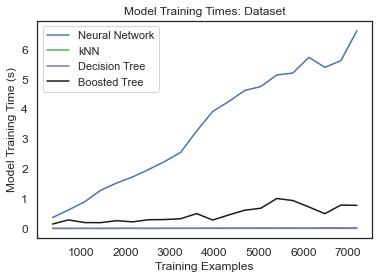

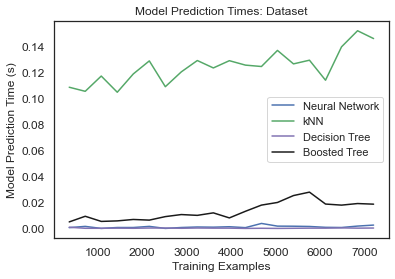

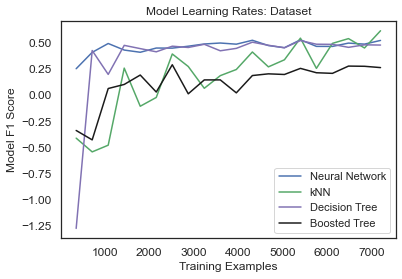

In [32]:
compare_fit_time(train_samp_MT, NN_fit_time_MT, kNN_fit_time_MT, 
                 DT_fit_time_MT, BT_fit_time_MT, 'Dataset')              
compare_pred_time(train_samp_MT, NN_pred_time_MT, kNN_pred_time_MT, 
                 DT_pred_time_MT, BT_pred_time_MT, 'Dataset')   
compare_learn_time(train_samp_MT, NN_cv_mean_MT, kNN_cv_mean_MT, 
                 DT_cv_mean_MT, BT_cv_mean_MT, 'Dataset')  

### Conclusions

- The model complexity and learning curve experiments were conducted on 70% of the overall datasets. The remaining 30% was set aside specifically for evaluating the models together. The plots above shows the model r2 score, training time, and  testing time for each algorithm when trained with different sizes of dataset.
- The Neural Network model showed the highest accuracy but takes the longest to train the data.
- Overall when taking into consideration the model accuracy, training and testing times, the Decision Tree model performed the best for the dataset.
- Model accuracy can possibly be improved by transforming the categorical variables or utilizing more data.